## Proses Instalasi

In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [19]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

## Prapemrosesan Data

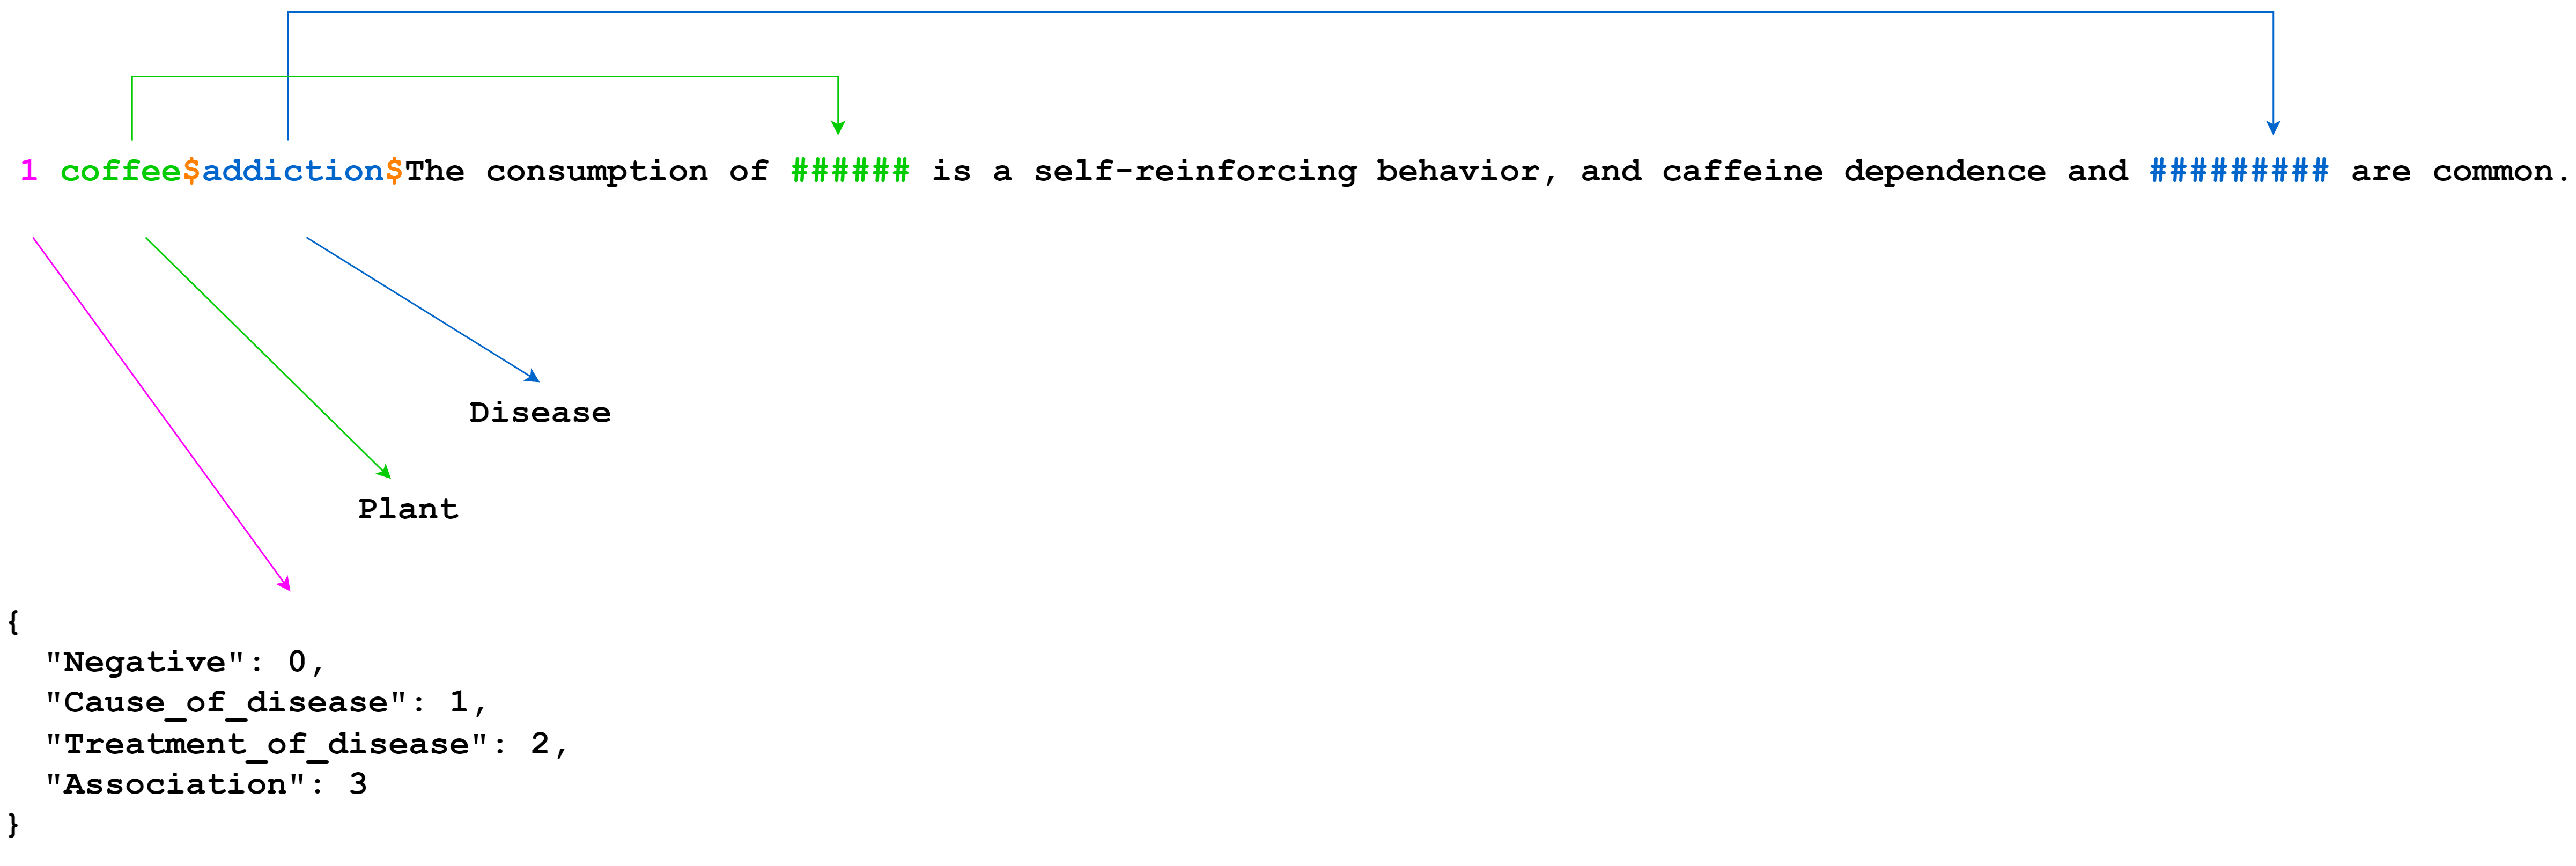

In [3]:
from IPython import display
display.Image("XtoT.png")

In [3]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [4]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split

# Train

### Encoding Undersampling

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Load data using get_train_test_pd() function
train_df, test_df = get_train_test_pd()

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
train_df, train_labels = rus.fit_resample(train_df[['text']], train_df['label'])

# Initialize BERT model
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)

# Define function for encoding text using BERT model
def encode_text(text):
    return bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_data = [encode_text(text) for text in train_df['text'].values]
test_data = [encode_text(text) for text in test_df['text'].values]

# Split train and test sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)


# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


Train data shape: (83, 512, 768), Train labels shape: (83,)
Val data shape: (21, 512, 768), Val labels shape: (21,)
Test data shape: (261, 512, 768), Test labels shape: (261,)


In [21]:
# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")

Train data shape: (104,), Train labels shape: (83,)
Val data shape: (261,), Val labels shape: (21,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


### Training and Test Set

In [6]:
#train_data, val_data, train_labels, val_labels 

x_train = train_data
x_test = val_data
y_train = train_labels
y_test = val_labels

In [7]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [8]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (83, 512, 768)
Size of training output data :  (83, 4)
Size of testing input data :  (21, 512, 768)
Size of testing output data :  (21, 4)


## Model Config

In [10]:
inputs = Input(name="Input", shape=(512, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [12]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = 'output-under/e40-dr03-b64-dim512'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

## Model Visualization

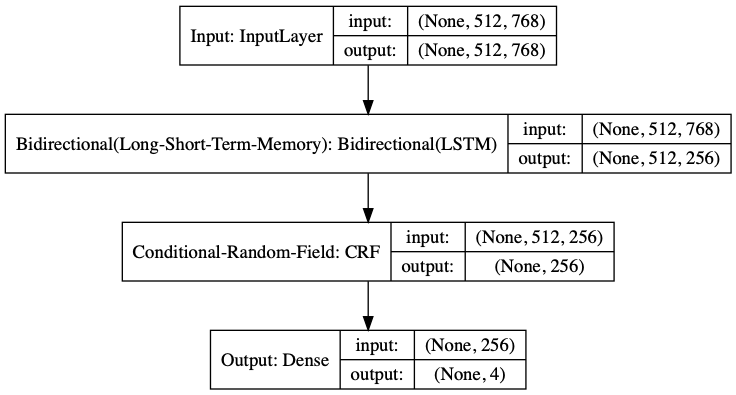

In [13]:
plot_model(model, to_file='model.png', show_shapes=True)

# Model Process

In [14]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 512, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1540      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 921,096
Trainable params: 921,096
Non-trainable params: 0
_________________________________________________________________


In [1]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

NameError: name 'model' is not defined

In [27]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Uji 1

In [16]:
# Save the latest val_acc best model file
filepath="output-under/e40-dr03-b64-dim512/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [17]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 83 samples, validate on 21 samples
Epoch 1/40
83/83 [==============================] - 4s 48ms/step - loss: 1.3888 - accuracy: 0.2048 - val_loss: 1.3828 - val_accuracy: 0.2381

Epoch 00001: val_accuracy improved from -inf to 0.23810, saving model to output-under/e40-dr03-b64-dim512/e-01-los-1.3828-acc-0.2381.hdf5
Epoch 2/40
83/83 [==============================] - 3s 41ms/step - loss: 1.3721 - accuracy: 0.3253 - val_loss: 1.3938 - val_accuracy: 0.1905

Epoch 00002: val_accuracy did not improve from 0.23810
Epoch 3/40
83/83 [==============================] - 3s 41ms/step - loss: 1.3266 - accuracy: 0.2771 - val_loss: 1.4520 - val_accuracy: 0.1905

Epoch 00003: val_accuracy did not improve from 0.23810
Epoch 4/40
83/83 [==============================] - 3s 39ms/step - loss: 1.3760 - accuracy: 0.3012 - val_loss: 1.3505 - val_accuracy: 0.2857

Epoch 00004: val_accuracy improved from 0.23810 to 0.28571, saving model to output-under/e40-dr03-b64-dim512/e-04-los-1.3505-acc-0.2857.hdf5

83/83 [==============================] - 4s 46ms/step - loss: 0.0455 - accuracy: 1.0000 - val_loss: 0.9114 - val_accuracy: 0.6667

Epoch 00039: val_accuracy did not improve from 0.71429
Epoch 40/40
83/83 [==============================] - 4s 48ms/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.9049 - val_accuracy: 0.6667

Epoch 00040: val_accuracy did not improve from 0.71429


In [45]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

21/21 [==============================] - 0s 9ms/step
The effect on the test set： [0.7133297920227051, 0.7142857313156128]


# Uji Skema 1

In [47]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [49]:
model = load_model(
  "output-under/e40-dr03-b64-1/per-rel-26-0.8095.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.80      0.80      0.80         5
    Cause_of_disease       0.62      0.83      0.71         6
Treatment_of_disease       1.00      0.50      0.67         4
         Association       1.00      1.00      1.00         6

            accuracy                           0.81        21
           macro avg       0.86      0.78      0.80        21
        weighted avg       0.85      0.81      0.81        21



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


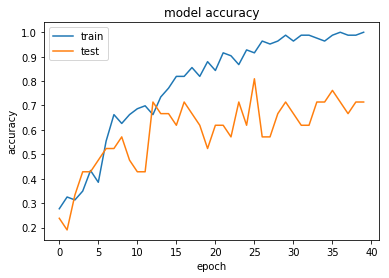

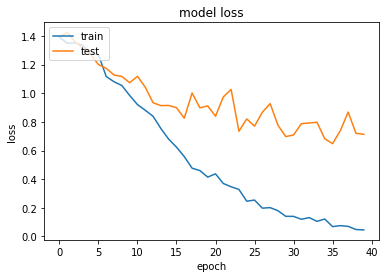

In [50]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.392438      0.238095  1.391893  0.277108
1   1.426350      0.190476  1.349344  0.325301
2   1.359643      0.333333  1.352429  0.313253
3   1.315261      0.428571  1.333789  0.349398
4   1.270229      0.428571  1.275773  0.433735
5   1.200688      0.476190  1.269480  0.385542
6   1.174061      0.523810  1.116928  0.554217
7   1.127793      0.523810  1.080215  0.662651
8   1.117574      0.571429  1.054258  0.626506
9   1.073871      0.476190  0.984627  0.662651
10  1.118307      0.428571  0.920952  0.686747
11  1.042626      0.428571  0.881407  0.698795
12  0.933870      0.714286  0.839380  0.662651
13  0.913597      0.666667  0.753750  0.734940
14  0.914971      0.666667  0.679411  0.771084
15  0.899131      0.619048  0.623726  0.819277
16  0.825904      0.714286  0.557340  0.819277
17  1.002090      0.666667  0.476646  0.855422
18  0.898390      0.619048  0.460005  0.819277
19  0.911821      0.523810  0.414178  0.879518
20  0.839716 

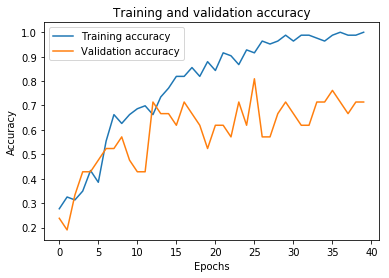

In [52]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Chart Loss and Accuracy

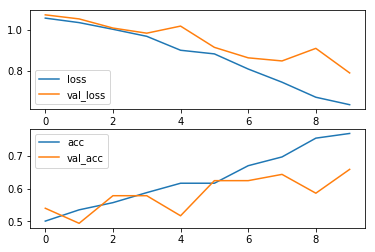

In [24]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

# Fold 1

In [20]:
# Save the latest val_acc best model file
filepath="results/fold1/16/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [22]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=16, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0668 - accuracy: 0.4799 - val_loss: 1.0294 - val_accuracy: 0.5479

Epoch 00001: val_accuracy did not improve from 0.56322
Epoch 2/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0211 - accuracy: 0.5621 - val_loss: 1.0465 - val_accuracy: 0.4674

Epoch 00002: val_accuracy did not improve from 0.56322
Epoch 3/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0009 - accuracy: 0.5516 - val_loss: 0.9537 - val_accuracy: 0.6054

Epoch 00003: val_accuracy improved from 0.56322 to 0.60536, saving model to results/fold1/16/per-rel-03-0.6054.hdf5
Epoch 4/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.9263 - accuracy: 0.6023 - val_loss: 0.9422 - val_accuracy: 0.5785

Epoch 00004: val_accuracy did not improve from 0.60536
Epoch 5/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.8706 - accurac


Epoch 00038: val_accuracy did not improve from 0.75096
Epoch 39/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.0862 - accuracy: 0.9608 - val_loss: 0.9424 - val_accuracy: 0.7433

Epoch 00039: val_accuracy did not improve from 0.75096
Epoch 40/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.0720 - accuracy: 0.9627 - val_loss: 1.0902 - val_accuracy: 0.7280

Epoch 00040: val_accuracy did not improve from 0.75096
Epoch 41/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.0831 - accuracy: 0.9618 - val_loss: 1.1373 - val_accuracy: 0.7011

Epoch 00041: val_accuracy did not improve from 0.75096
Epoch 42/50
1046/1046 [==============================] - 6s 5ms/step - loss: 0.1060 - accuracy: 0.9589 - val_loss: 1.0582 - val_accuracy: 0.7280

Epoch 00042: val_accuracy did not improve from 0.75096
Epoch 43/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.0893 - accuracy: 0.9579 - val_loss: 1.0246 - val_accuracy: 0.

## Uji Fold1 - 16

In [23]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [24]:
model = load_model(
  "results/fold1/16/per-rel-31-0.7510.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.72      0.81      0.76       117
    Cause_of_disease       0.68      0.62      0.65        40
Treatment_of_disease       0.82      0.74      0.78        99
         Association       1.00      0.60      0.75         5

            accuracy                           0.75       261
           macro avg       0.80      0.69      0.73       261
        weighted avg       0.76      0.75      0.75       261



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


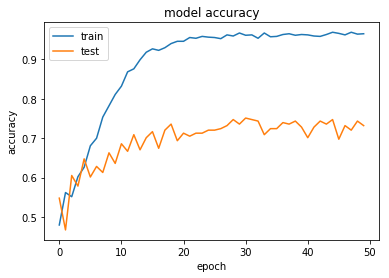

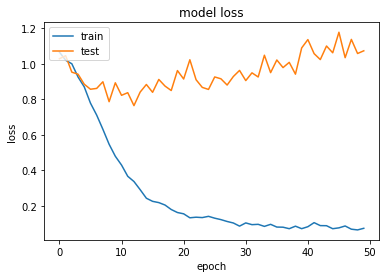

In [25]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.029444      0.547893  1.066839  0.479924
1   1.046466      0.467433  1.021094  0.562141
2   0.953686      0.605364  1.000900  0.551625
3   0.942213      0.578544  0.926321  0.602294
4   0.885674      0.647510  0.870631  0.626195
5   0.857558      0.601533  0.779220  0.680688
6   0.862233      0.628352  0.711777  0.699809
7   0.899592      0.613027  0.631737  0.753346
8   0.787330      0.662835  0.547627  0.782027
9   0.893879      0.636015  0.479991  0.810707
10  0.823287      0.685824  0.430479  0.831740
11  0.838121      0.666667  0.367162  0.868069
12  0.765220      0.708812  0.337649  0.875717
13  0.841616      0.670498  0.291691  0.898662
14  0.884310      0.701149  0.243531  0.917782
15  0.840224      0.716475  0.226074  0.926386
16  0.912739      0.674330  0.218940  0.922562
17  0.875387      0.720307  0.205222  0.929254
18  0.850328      0.735632  0.180070  0.939771
19  0.962635      0.693487  0.163062  0.945507
20  0.915195 

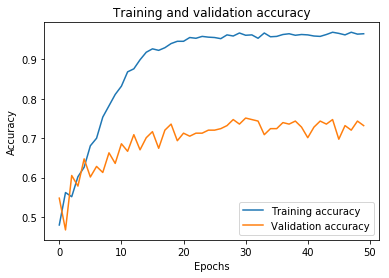

In [27]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Chart Loss & Accuracy

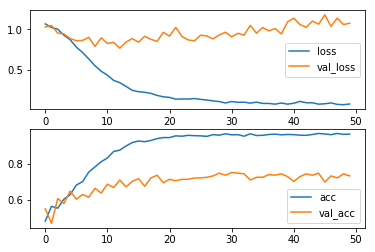

In [28]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

## Fold1 - 32

In [29]:
# Save the latest val_acc best model file
filepath="results/fold1/32/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [31]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=32, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0543 - accuracy: 0.9665 - val_loss: 1.1970 - val_accuracy: 0.7318

Epoch 00001: val_accuracy did not improve from 0.76245
Epoch 2/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0557 - accuracy: 0.9675 - val_loss: 1.1070 - val_accuracy: 0.7471

Epoch 00002: val_accuracy did not improve from 0.76245
Epoch 3/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0561 - accuracy: 0.9637 - val_loss: 1.1312 - val_accuracy: 0.7280

Epoch 00003: val_accuracy did not improve from 0.76245
Epoch 4/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0527 - accuracy: 0.9723 - val_loss: 1.1674 - val_accuracy: 0.7356

Epoch 00004: val_accuracy did not improve from 0.76245
Epoch 5/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0557 - accuracy: 0.9627 - val_loss: 1.1892 - val_accuracy: 0.7356

Epoch 00


Epoch 00041: val_accuracy did not improve from 0.76245
Epoch 42/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0542 - accuracy: 0.9685 - val_loss: 1.2632 - val_accuracy: 0.7203

Epoch 00042: val_accuracy did not improve from 0.76245
Epoch 43/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0560 - accuracy: 0.9713 - val_loss: 1.2649 - val_accuracy: 0.7433

Epoch 00043: val_accuracy did not improve from 0.76245
Epoch 44/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0514 - accuracy: 0.9685 - val_loss: 1.2521 - val_accuracy: 0.7241

Epoch 00044: val_accuracy did not improve from 0.76245
Epoch 45/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0531 - accuracy: 0.9637 - val_loss: 1.4124 - val_accuracy: 0.7050

Epoch 00045: val_accuracy did not improve from 0.76245
Epoch 46/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0764 - accuracy: 0.9627 - val_loss: 1.1397 - val_accuracy: 0.

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


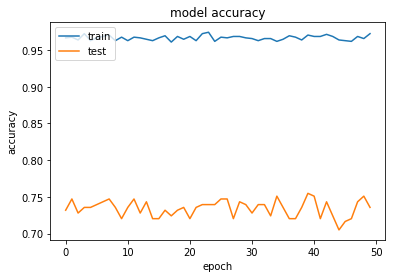

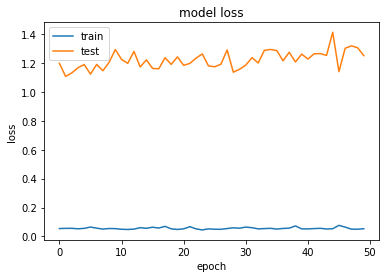

In [32]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.196967      0.731801  0.054308  0.966539
1   1.106979      0.747126  0.055665  0.967495
2   1.131209      0.727969  0.056062  0.963671
3   1.167365      0.735632  0.052717  0.972275
4   1.189225      0.735632  0.055734  0.962715
5   1.122731      0.739464  0.064858  0.966539
6   1.190083      0.743295  0.057072  0.968451
7   1.146172      0.747126  0.050660  0.970363
8   1.204178      0.735632  0.054761  0.962715
9   1.293000      0.720307  0.053836  0.967495
10  1.224247      0.735632  0.049449  0.962715
11  1.197263      0.747126  0.048147  0.967495
12  1.279871      0.727969  0.050329  0.966539
13  1.172315      0.743295  0.060565  0.964627
14  1.221429      0.720307  0.056071  0.962715
15  1.161763      0.720307  0.063508  0.966539
16  1.159864      0.731801  0.057831  0.969407
17  1.236308      0.724138  0.069621  0.960803
18  1.189988      0.731801  0.052415  0.968451
19  1.242085      0.735632  0.048271  0.964627
20  1.183263 

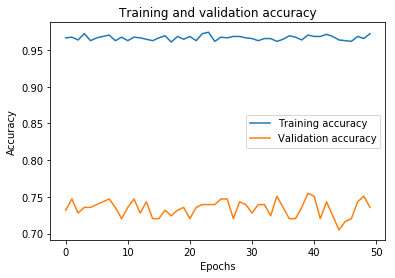

In [34]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Chart Loss & Accuracy

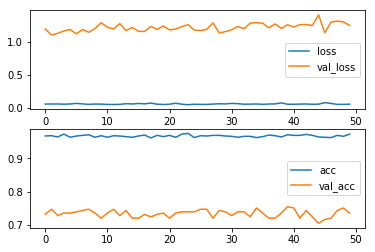

In [35]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

## Fold1 - 8

In [36]:
# Save the latest val_acc best model file
filepath="results/fold1/8/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [37]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=8, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.2387 - accuracy: 0.9140 - val_loss: 1.0860 - val_accuracy: 0.6590

Epoch 00001: val_accuracy improved from -inf to 0.65900, saving model to results/fold1/8/per-rel-01-0.6590.hdf5
Epoch 2/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.2262 - accuracy: 0.9101 - val_loss: 1.0431 - val_accuracy: 0.6590

Epoch 00002: val_accuracy did not improve from 0.65900
Epoch 3/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.1278 - accuracy: 0.9465 - val_loss: 1.1133 - val_accuracy: 0.7203

Epoch 00003: val_accuracy improved from 0.65900 to 0.72031, saving model to results/fold1/8/per-rel-03-0.7203.hdf5
Epoch 4/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.0902 - accuracy: 0.9646 - val_loss: 1.1255 - val_accuracy: 0.7356

Epoch 00004: val_accuracy improved from 0.72031 to 0.73563, saving model to results/fold1/8

1046/1046 [==============================] - 9s 9ms/step - loss: 0.0524 - accuracy: 0.9675 - val_loss: 1.3288 - val_accuracy: 0.7011

Epoch 00040: val_accuracy did not improve from 0.75862
Epoch 41/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.0534 - accuracy: 0.9598 - val_loss: 1.2500 - val_accuracy: 0.7318

Epoch 00041: val_accuracy did not improve from 0.75862
Epoch 42/50
1046/1046 [==============================] - 10s 9ms/step - loss: 0.0528 - accuracy: 0.9646 - val_loss: 1.4476 - val_accuracy: 0.7126

Epoch 00042: val_accuracy did not improve from 0.75862
Epoch 43/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.0468 - accuracy: 0.9704 - val_loss: 1.3618 - val_accuracy: 0.7433

Epoch 00043: val_accuracy did not improve from 0.75862
Epoch 44/50
1046/1046 [==============================] - 10s 9ms/step - loss: 0.0514 - accuracy: 0.9627 - val_loss: 1.3016 - val_accuracy: 0.7356

Epoch 00044: val_accuracy did not improve from 0.75862
Epoch

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


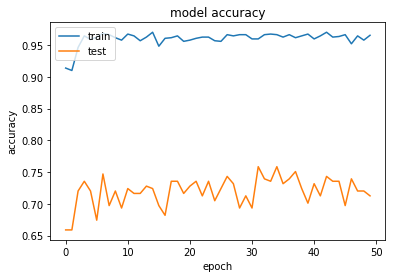

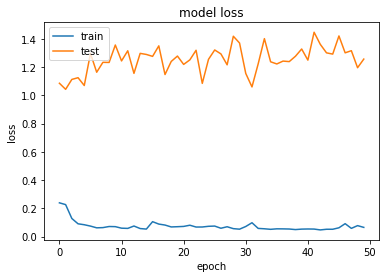

In [38]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.086049      0.659004  0.238735  0.913958
1   1.043117      0.659004  0.226157  0.910134
2   1.113259      0.720307  0.127778  0.946463
3   1.125480      0.735632  0.090152  0.964627
4   1.070064      0.720307  0.083516  0.958891
5   1.297169      0.674330  0.073888  0.962715
6   1.164172      0.747126  0.061641  0.968451
7   1.234382      0.697318  0.063161  0.966539
8   1.233575      0.720307  0.070979  0.961759
9   1.357137      0.693487  0.069972  0.957935
10  1.244438      0.724138  0.059116  0.967495
11  1.316220      0.716475  0.057587  0.964627
12  1.156182      0.716475  0.074422  0.956979
13  1.297864      0.727969  0.056489  0.962715
14  1.290223      0.724138  0.052732  0.970363
15  1.276627      0.697318  0.105218  0.948375
16  1.351060      0.681992  0.088151  0.960803
17  1.147906      0.735632  0.081253  0.961759
18  1.240597      0.735632  0.067883  0.964627
19  1.278732      0.716475  0.069559  0.956023
20  1.219665 

# Predict

In [51]:
! python model_predict.py

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2022-09-16 16:52:46.710520: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Use tf.cast instead.
tobacco$lung cancer$In conclusion, variation in ########### rates between populations may be due to: (1) differences in effective exposure to ####### smoke carcinogens; (2) differences in factors which modify the effect of ####### smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for ###########.
I:BERT_VEC:[graph:opt: 48]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 54]:build graph...

For more information, please see:
  * https://github.com/tensorflow/community/blob/